<script>
    document.querySelector('head').innerHTML += '<style>.slides { zoom: 1 !important; }</style>';
</script>

# Week 10 - Unsupervised Learning
### Dr. David Elliott

1.4. [Hierarchical Clustering](#hierarchical)

1.5. [DBSCAN](#DBSCAN)

# Hierarchical Clustering  <a id='hierarchical'></a>

Hierarchical clustering is an approach to clustering which does not require that we commit to a apriori number of clusters.

Instead we can determine the number of clsuters using a tree-based representation of the observations, called a dendrogram<sup>1</sup>.

__TODO__
- add info from pg.895 ML prop perspective

In [61]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
import os
from IPython.display import Image
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
import warnings 

matplotlib.rcParams['animation.embed_limit'] = 30000000.0
plt.rcParams['figure.dpi'] = 120

In [4]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# set a random seed
np.random.seed(1)

# A list of centres of clusters
true_centres = [[-5, 0], [0, 0], [2, 3]]

points, clusters = make_blobs(
    n_samples=[18, 11, 16], # number of samples in each cluster
    centers=true_centres,     # where are the centres?
)


labelled_points = pd.DataFrame({'cluster': clusters,
                                'x1': points[:, 0],
                                'x2': points[:, 1]})

def clusters_plt(title):
    sns.scatterplot(x = 'x1', y = 'x2', hue="cluster", data = labelled_points, alpha=0.7, 
                    palette = CB_color_cycle[:3], legend=False)
    plt.title(title)
    plt.show()

__Agglomerative__ (or bottom-up) clustering is the most common type of hierarchical clustering and refers to the fact that a dendrogram (generally depicted as an upside-down tree) is built starting from the leaves and combining clusters up to the trunk<sup>1</sup>.

Each leaf of the dendrogram represents an observation and as we move up the tree, some leaves begin to fuse into branches. These correspond to observations that are similar to each other. As we move higher up the tree, branches themselves fuse, either with leaves or other branches<sup>1</sup>.

The earlier (lower in the tree) fusions occur, the more similar the groups of observations are to each other. On the other hand, observations that fuse later (near the top of the tree) can be quite different<sup>1</sup>.

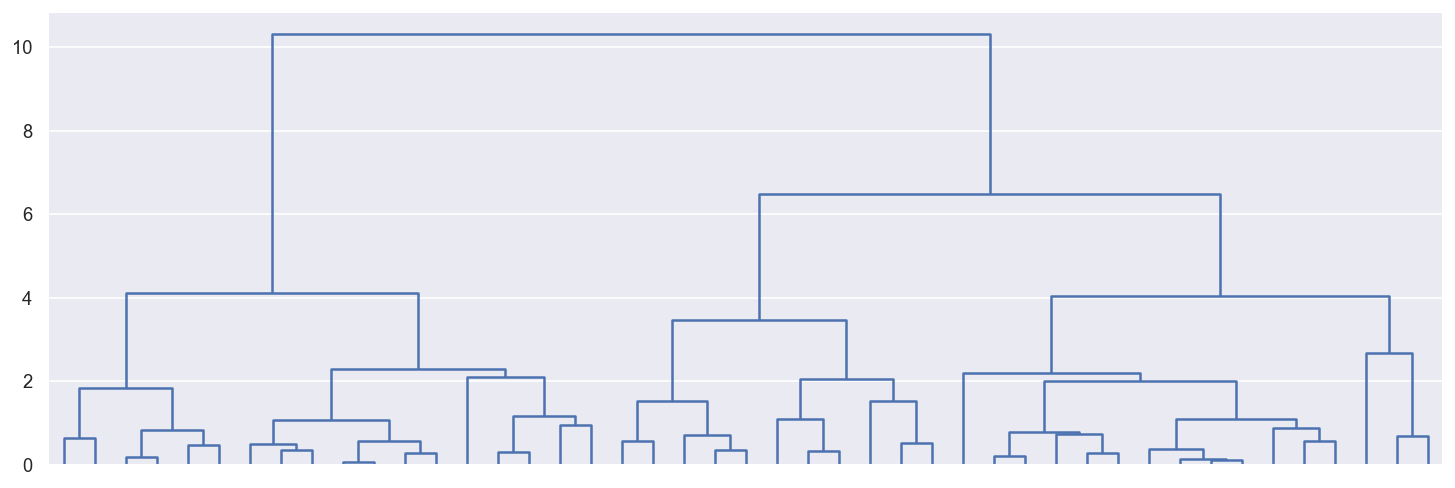

In [5]:
fig, axes = plt.subplots(figsize=(15,5))
cluster = hierarchy.dendrogram(hierarchy.complete(points), ax= axes, color_threshold=0)
axes.get_xaxis().set_ticks([])
plt.show()

## Data Example

For this notebook we will use the following data generated data. There are three distinct classes, shown in separate colors. However, we will treat these class labels as unknown and will seek to cluster the observations in order to discover the classes from the data<sup>1</sup>.

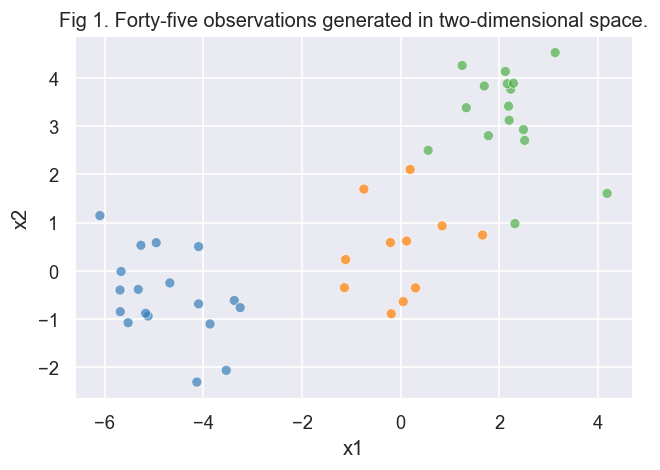

In [6]:
clusters_plt("Fig 1. Forty-five observations generated in two-dimensional space.")

Each leaf of the dendrogram represents one of the 45 observations.

For any two observations, we can look for the point in the tree where branches containing those two observations are first fused. 

The _height_ of this fusion, indicates how different the two observations are. Observations that fuse at the bottom of the tree are quite similar to each other, whereas observations that fuse close to the top will generally be quite different<sup>1</sup>.

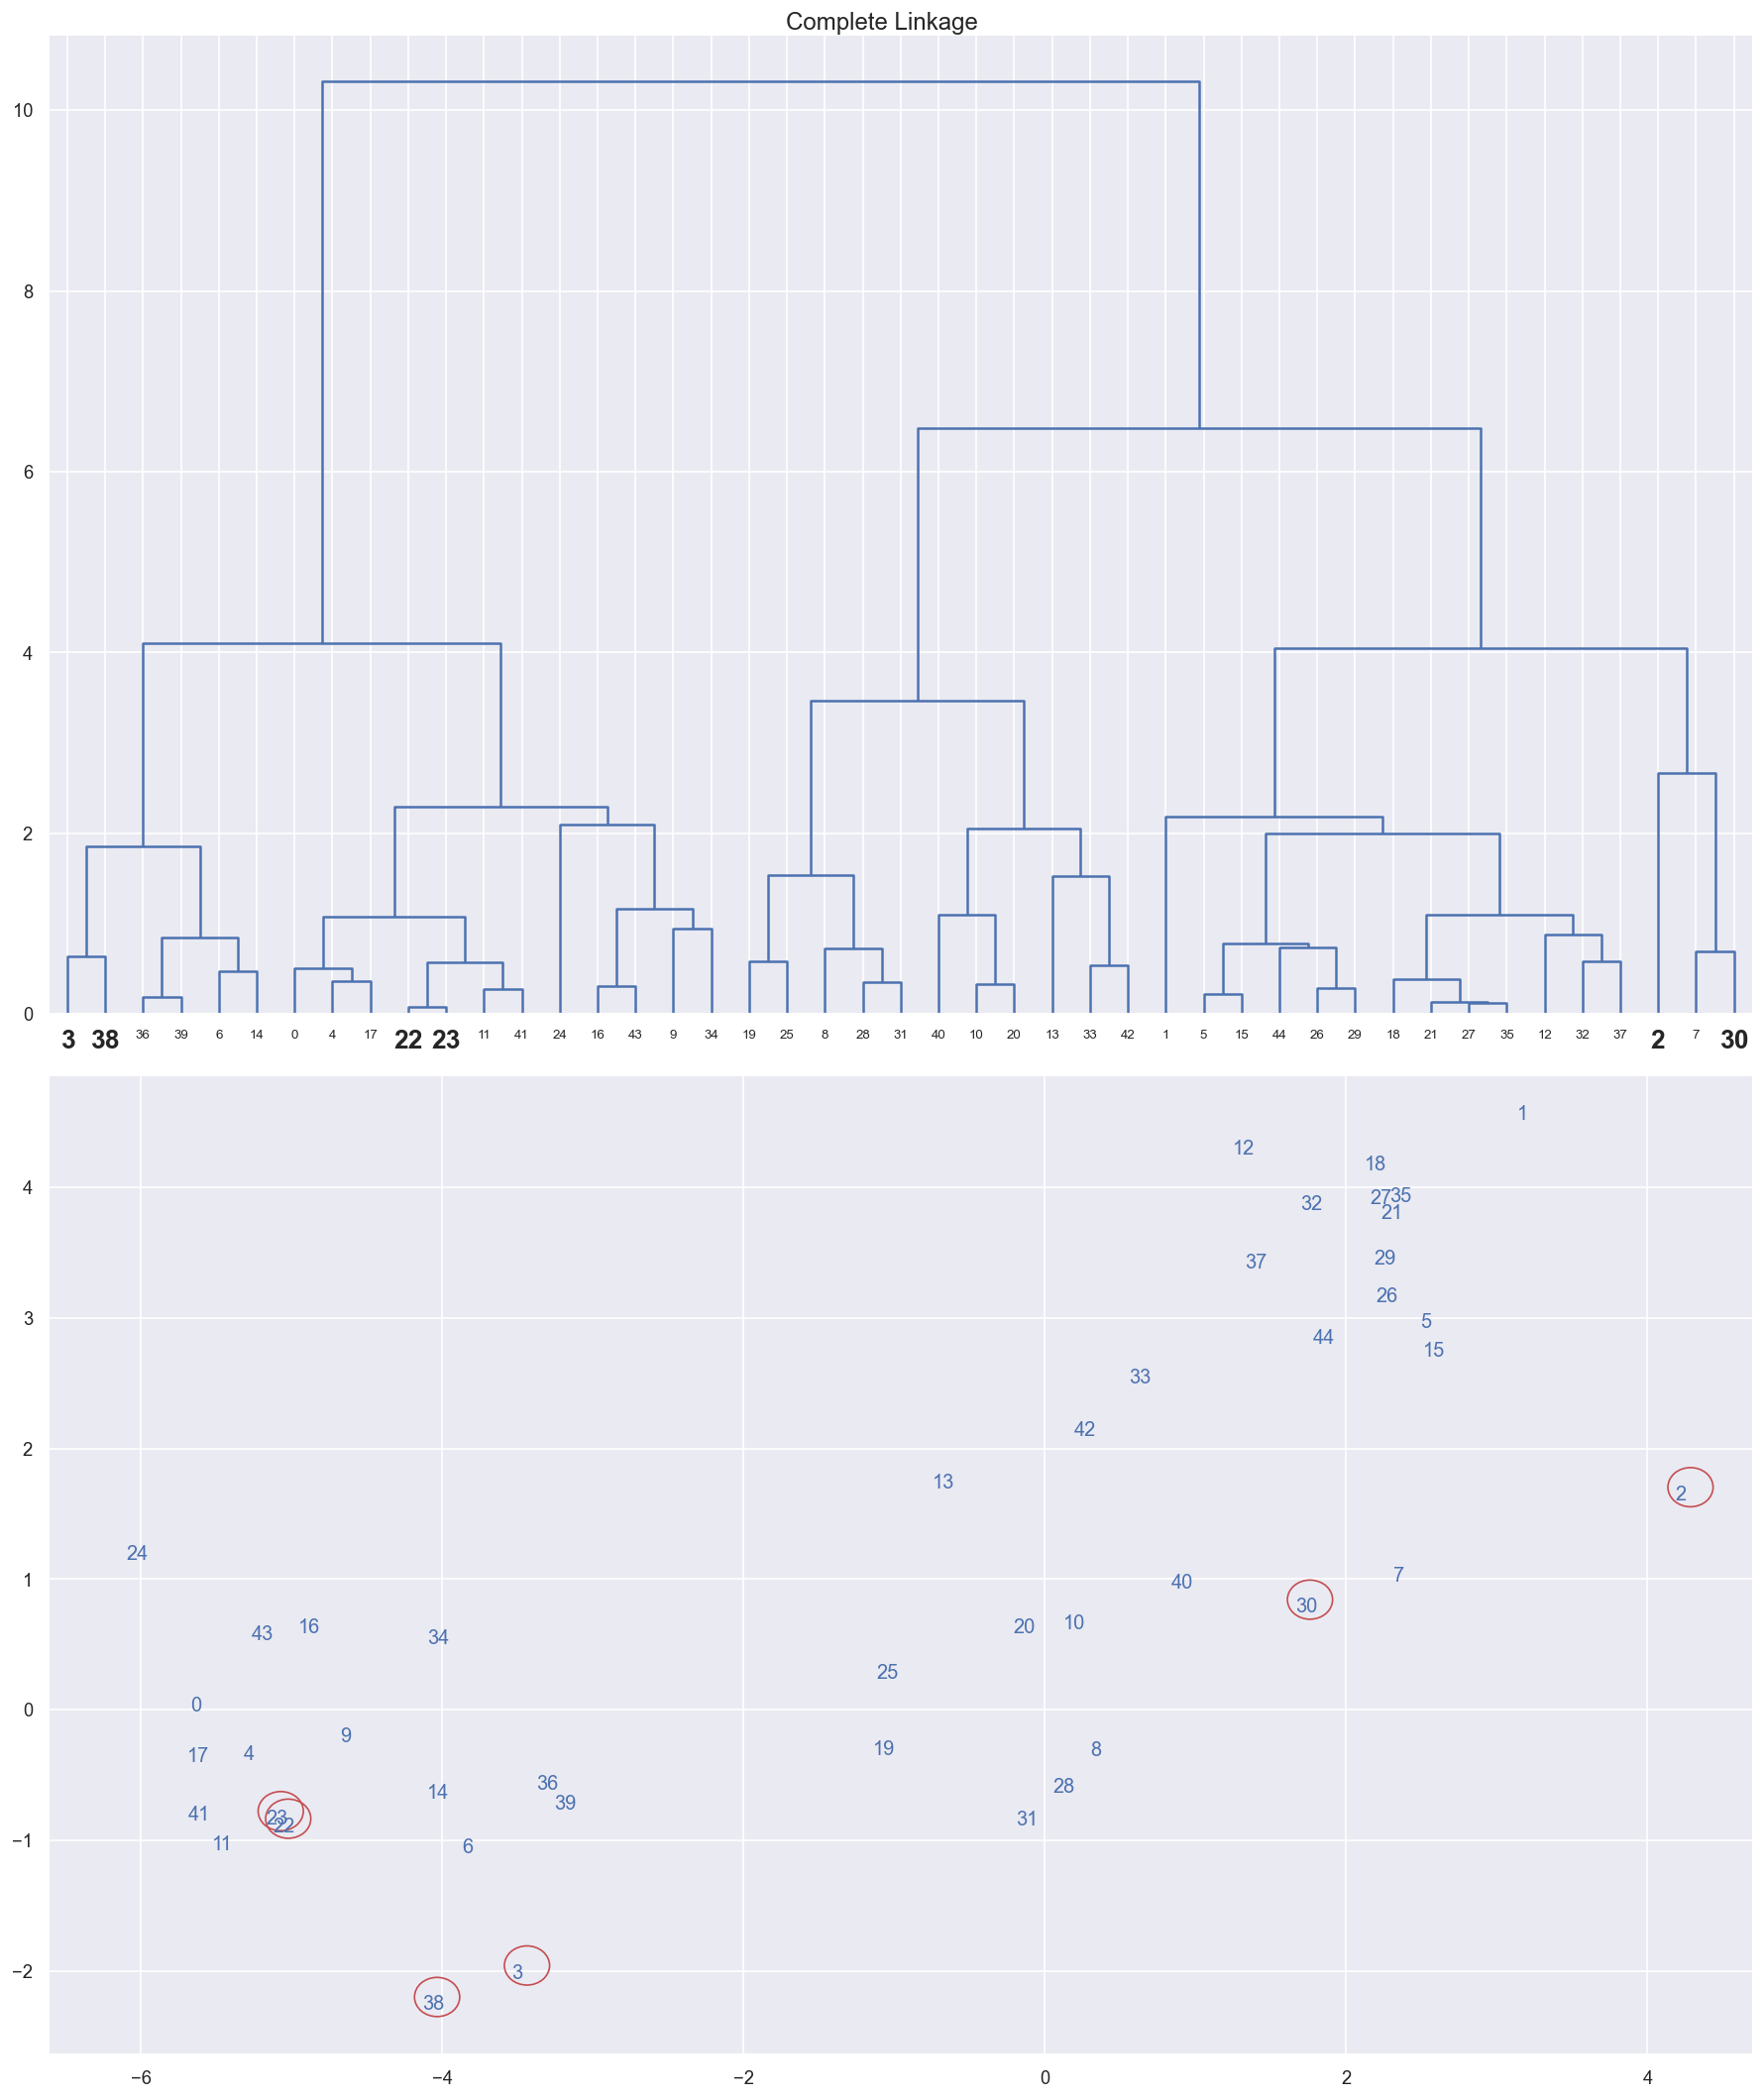

In [8]:
def highlight_points(X, highlight, ax):
    for h in highlight:

        circle = plt.Circle((X[h,0]+0.1, X[h,1]+0.1), 0.15, color='r',fill=False)
        ax.add_patch(circle)


def numbered_scatter(X, ax=None, color_dict={}, title=None, highlight=None):
    
    if ax:
        plt.sca(ax)
    else:
        sns.set(rc={"figure.figsize":(10,5)})
        
    if not color_dict:
        for i in range(len(X)):
            color_dict[i]="purple"

    ax = sns.scatterplot(x=X[:,0], y=X[:,1], alpha=0)
    
    if title:
        ax.set(title=title)
    # label points on the plot
    for i, [x, y] in enumerate(zip(X[:,0], X[:,1])):
        # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
        plt.text(x = x, # x-coordinate position of data label
        y = y, # y-coordinate position of data label
        s = "{:.0f}".format(i), # data label, formatted to ignore decimals
        color = color_dict[i]) # set colour
        
    if highlight:
        highlight_points(X, highlight, ax)

def heir_scat_plot(linkage, X, threshold=0, highlight=None):
    #sns.set_theme(style = "whitegrid") 
    links_list = ["Complete", "Average", "Single"]
    if linkage not in links_list:
        raise NameError("linkage needs to be in: " +str(links_list))
    
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,18))
    
    plt.suptitle(linkage+" Linkage")
    
    # heirarchy plot
    plt.sca(ax1)
    if linkage == "Complete":
        links = hierarchy.complete(X)
    elif linkage == "Average":
        links = hierarchy.average(X)
    elif linkage == "Single":
        links = hierarchy.single(X)
    hierarchy.set_link_color_palette(CB_color_cycle)
    cluster = hierarchy.dendrogram(links, color_threshold=threshold)
    
    if threshold:
        plt.hlines(threshold, xmin=0., xmax=pd.DataFrame(cluster['icoord']).max().max(), colors ='k', linestyles = 'dashed')
    
    if highlight:
        ax_txt_labels = ax1.get_xticklabels()
        for label in ax_txt_labels:
            if int(label.get_text()) in highlight:
                label.set_fontweight("bold")
                label.set_fontsize(label.get_fontsize()*2)
    

    plt.xticks(rotation = 0)
    
    numbered_scatter(X, ax2, dict(zip(cluster['leaves'], cluster['leaves_color_list'])), highlight=highlight)

    plt.tight_layout()
    plt.show()
    
heir_scat_plot("Complete", points, highlight=[38,3,22,23,2,30])

In order to identifying clusters using a dendrogram we make a horizontal cut across it. The distinct sets of observations beneath the cut can be interpreted as clusters.

A dendrogram can be used to obtain any number of clusters. In practice, it is common select by eye a sensible number of clusters based on the heights of the fusions and the number of clusters desired.

However, often the choice of where to cut the dendrogram is not so clear.

__Notes__
- _"The height of the cut to the dendrogram serves the same role as the K in K-means clustering: it controls the number of clusters obtained."_<sup>1</sup>
- _"the dendrogram from the left-hand panel, cut at a height of nine (indicated by the dashed line). This cut results in two distinct clusters, shown in different colors. Right: the dendrogram from the left-hand panel, now cut at a height of five. This cut results in three distinct clusters, shown in different colors."_<sup>1</sup>

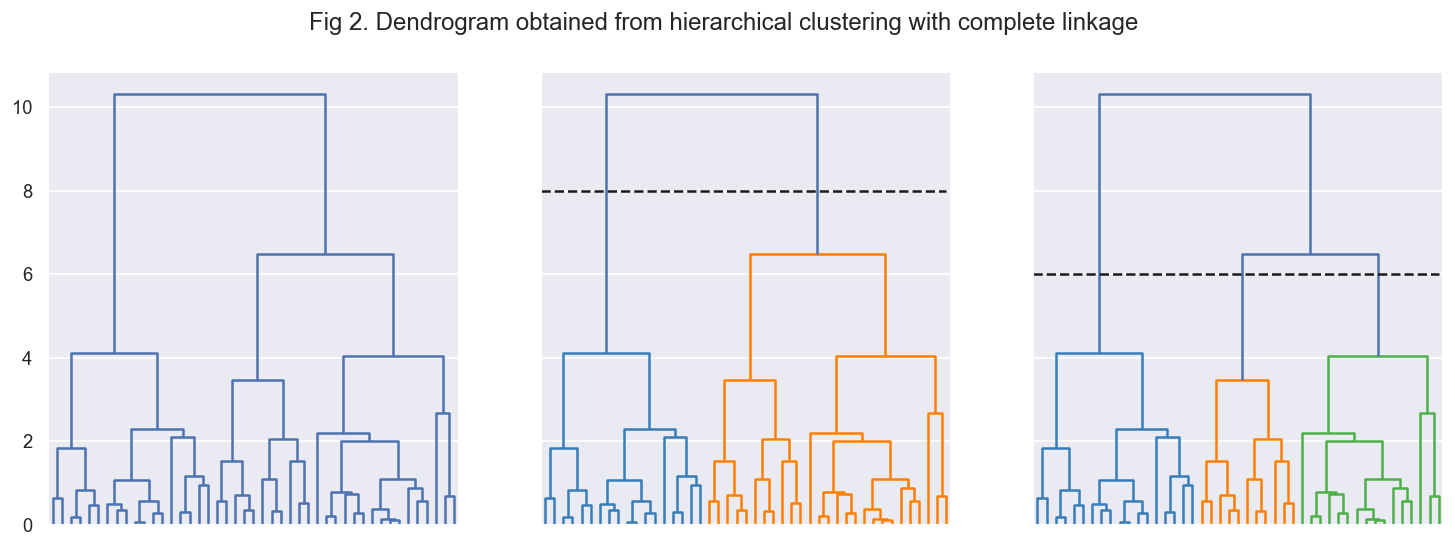

In [9]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)

axes = axes.flatten()

thesh_list = [0,8,6]

for i in range(3):
    
    plt.sca(axes[i])
    cluster = hierarchy.dendrogram(hierarchy.complete(points), ax=axes[i], color_threshold=thesh_list[i])
    axes[i].get_xaxis().set_ticks([])
    if thesh_list[i]:
        plt.hlines(thesh_list[i], xmin=0., xmax=pd.DataFrame(cluster['icoord']).max().max(), colors ='k', linestyles = 'dashed')
        
plt.suptitle("Fig 2. Dendrogram obtained from hierarchical clustering with complete linkage")
plt.show()

In [29]:
row_clusters = hierarchy.complete(points)
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])]).head()

row label 1  row label 2  distance  no. of items in clust.
cluster 1         22.0         23.0  0.076208                     2.0
cluster 2         27.0         35.0  0.125870                     2.0
cluster 3         21.0         46.0  0.135057                     3.0
cluster 4         36.0         39.0  0.191957                     2.0
cluster 5          5.0         15.0  0.223856                     2.0

Heirarchical clustering dendrograms are oten used in combination with a __heat map__, which represent each individual value with a color<sup>2</sup>.

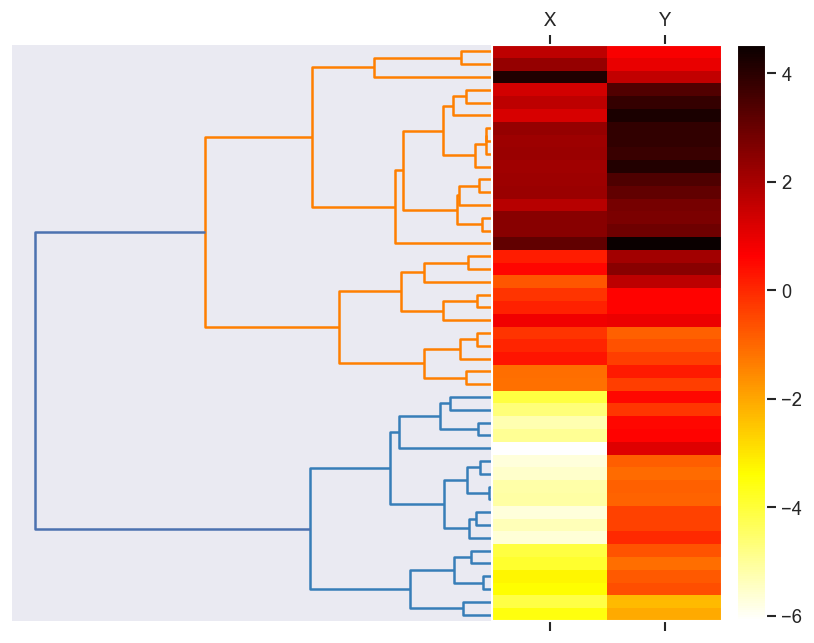

In [62]:
# altered from https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch11/ch11.ipynb

df = pd.DataFrame(points, columns = ['X', 'Y'])

# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.5, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = hierarchy.dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
    i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.59, 0.1, 0.3, 0.6])  # x-pos, y-pos, width, height
plt.grid(False)
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r', aspect='auto')
fig.colorbar(cax)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    axm.set_xticklabels([''] + list(df_rowclust.columns))
    axm.set_yticklabels([''])

#plt.savefig('images/11_12.png', dpi=300)
plt.show()

## The Hierarchical Clustering Algorithm<sup>1</sup>

> 1. Begin with n observations and a measure (such as Euclidean distance) of all the $({n \atop 2}) = \frac{n(n−1)}{2}$  pairwise dissimilarities. Treat each observation as its own cluster.
> 
> 2. For $i = n, n−1 , \ldots , 2$:
> 
>    (a) Examine all pairwise inter-cluster dissimilarities among the $i$ clusters and identify the pair of clusters that are least dissimilar (that is, most similar). Fuse these two clusters. The dissimilarity between these two clusters indicates the height in the dendrogram at which the fusion should be placed.
>
>    (b) Compute the new pairwise inter-cluster dissimilarities among the $i − 1$ remaining clusters.

__Note__
- The algorithm uses a dissimilarity measure between each pair of observations (e.g. Euclidean distance).

- It then proceeds iteratively starting at the bottom of the dendrogram where each observation is treat as its own cluster. Then the two clusters that are most similar to each other are fused so that there now are $n − 1$ clusters. The algorithm then proceeds in this fashion until all of the observations belong to one single cluster.

__TODO__
- Time allowing, do an animated version of Fig. 10.11 from intro to stats learning, showing the grouping step by step. Probably to make life easier color the numbered points as you go.
- Cant get the figure to change color for the final class... and I can't get the line between the two 

In [21]:
from matplotlib import animation, rc
from IPython.display import HTML
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

kclust = labelled_points[['x1', 'x2']]

def update_plot(i, kclust, dist_df, scat1, line1, final_colors, updated_colors):
    try:
    
        if i in [0,1]:
            # set 1 standard color
            scat1.set_array(updated_colors)
            line1.set_ydata([0])
            line1.set_xdata([0])
        else:
            if (i % 2) == 0:
                line1.set_ydata([0])
                line1.set_xdata([0])

                child_1 = dist_df['child_1'][int(i/2)-1]
                child_2 = dist_df['child_2'][int(i/2)-1]

                if child_1 < len(final_colors):
                    updated_colors[child_1]=final_colors[child_1]
                if child_2 < len(final_colors):
                    updated_colors[child_2]=final_colors[child_2]

                # changes color
                scat1.set_array(updated_colors)
            else:
                child_1 = dist_df['child_1'][int(i-1/2)-2]
                child_2 = dist_df['child_2'][int(i-1/2)-2]
                if child_1 < len(final_colors) and child_2 < len(final_colors):
                    line1.set_xdata([kclust['x1'][child_1]])
                    line1.set_ydata([kclust['x2'][child_2]])
                # else - you'll have to work out the line to the average of the cluster which may be tricky
                    
    except:
        pass
        # for testing
        #print(i)
                
    
    return scat1,

def heir_vis(n_clusters=3, random_state=1):
  
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average', compute_distances =True)
    cluster.fit(points)

    dist_df = pd.DataFrame(cluster.children_,cluster.distances_).reset_index()
    dist_df.columns = ["distances", "child_1", "child_2"]

    final_colors = cluster.labels_
    updated_colors = np.array([n_clusters+1]*len(final_colors))

    fig = plt.figure(figsize =(5,5))

    scat1 = plt.scatter(kclust['x1'], kclust['x2'], c=final_colors, cmap=plt.cm.tab10, alpha=0.7)
    line1, = plt.plot([],[])
    ani = animation.FuncAnimation(fig, update_plot, 
                                  frames=range((len(dist_df)*2)-2),
                                  fargs=(kclust, dist_df, scat1, line1, final_colors, updated_colors),
                                  interval=100,
                                 )

    plt.close()
    # Note: below is the part which makes it work on Colab
    rc('animation', html='jshtml')
    return ani

heir_vis()

## Dissimilarity Measure

For this to work, the dissimilarity between a pair of observations also needs to be extended to a pair of groups of observations (linkage).

A summary of the four most commonly-used types of linkage in hierarchical clustering<sup>1</sup>

__Complete__
- Maximal intercluster dissimilarity
- Compute all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and record the largest of these dissimilarities.

__Single__
- Minimal intercluster dissimilarity. 
- Compute all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and record the smallest of these dissimilarities. 
- Single linkage can result in extended, trailing clusters in which single observations are fused one-at-a-time.

__Average__
- Mean intercluster dissimilarity. 
- Compute all pairwise dissimilarities between the observations in cluster A and the observations in cluster B, and record the average of these dissimilarities.

__Centeroid__
- Dissimilarity between the centroid for cluster A (a mean vector of length p) and the centroid for cluster B. 
- Centroid linkage can result in undesirable inversions.

__TODO__
- Diagram to demonstrate the other two linkages as well

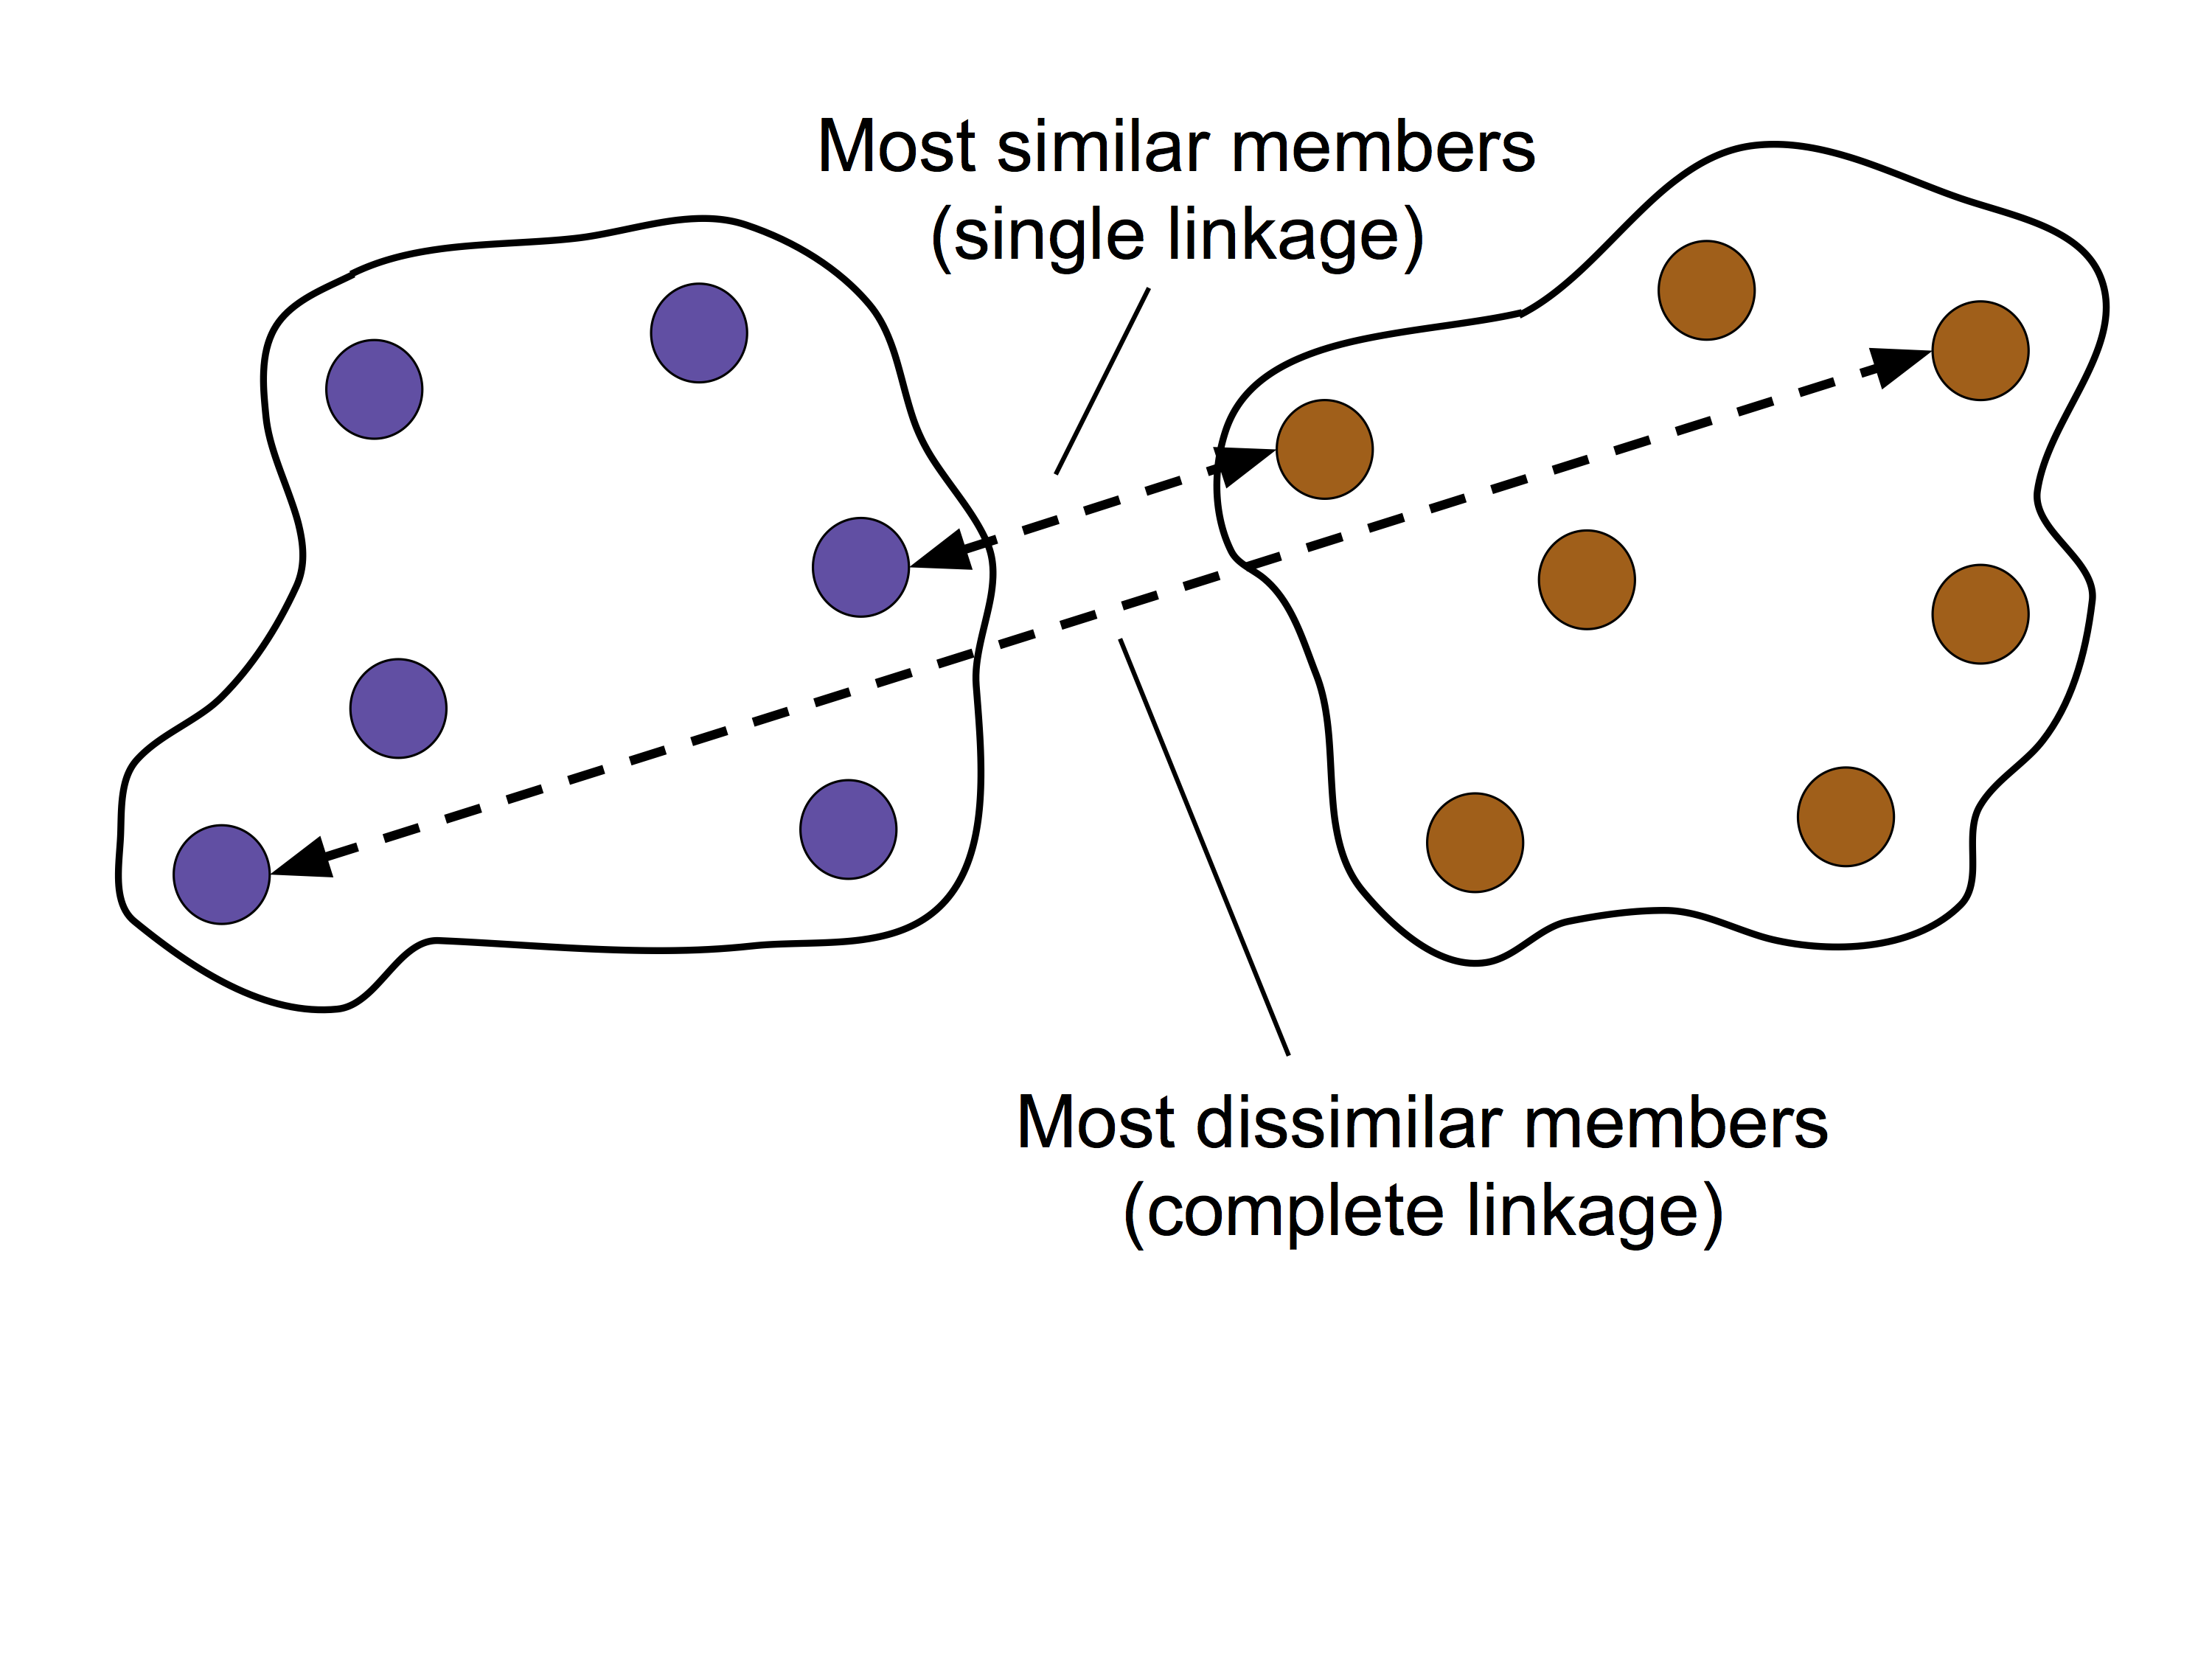

In [11]:
# https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch11/ch11.ipynb
Image(filename='11_07.png', width=400)

_"Average, complete, and single linkage are most popular among statisticians. Average and complete linkage are generally preferred over single linkage, as they tend to yield more balanced dendrograms."_<sup>1</sup>

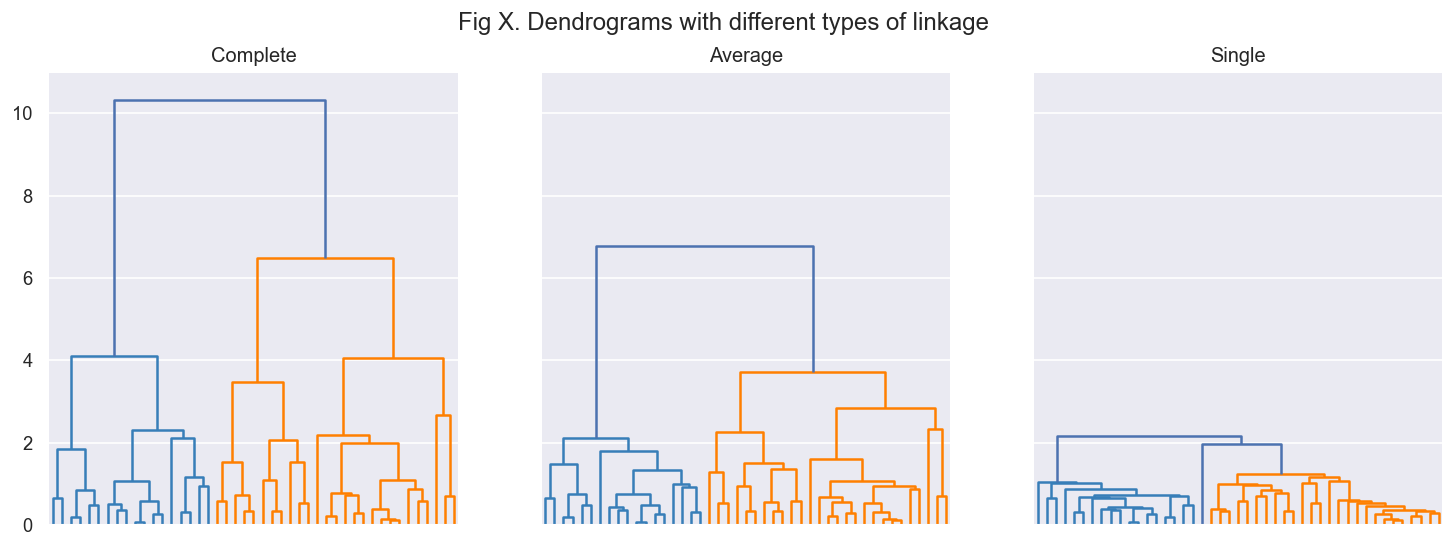

In [16]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey=True)

axes = axes.flatten()

for i, (links, title) in enumerate(zip([hierarchy.complete(points), hierarchy.average(points), hierarchy.single(points)],
                                       ["Complete", "Average", "Single"])):
    
    plt.sca(axes[i])
    cluster = hierarchy.dendrogram(links, ax=axes[i])
    axes[i].get_xaxis().set_ticks([])
    plt.title(title)
        
plt.ylim(0,11)
plt.suptitle("Fig X. Dendrograms with different types of linkage")
plt.show()

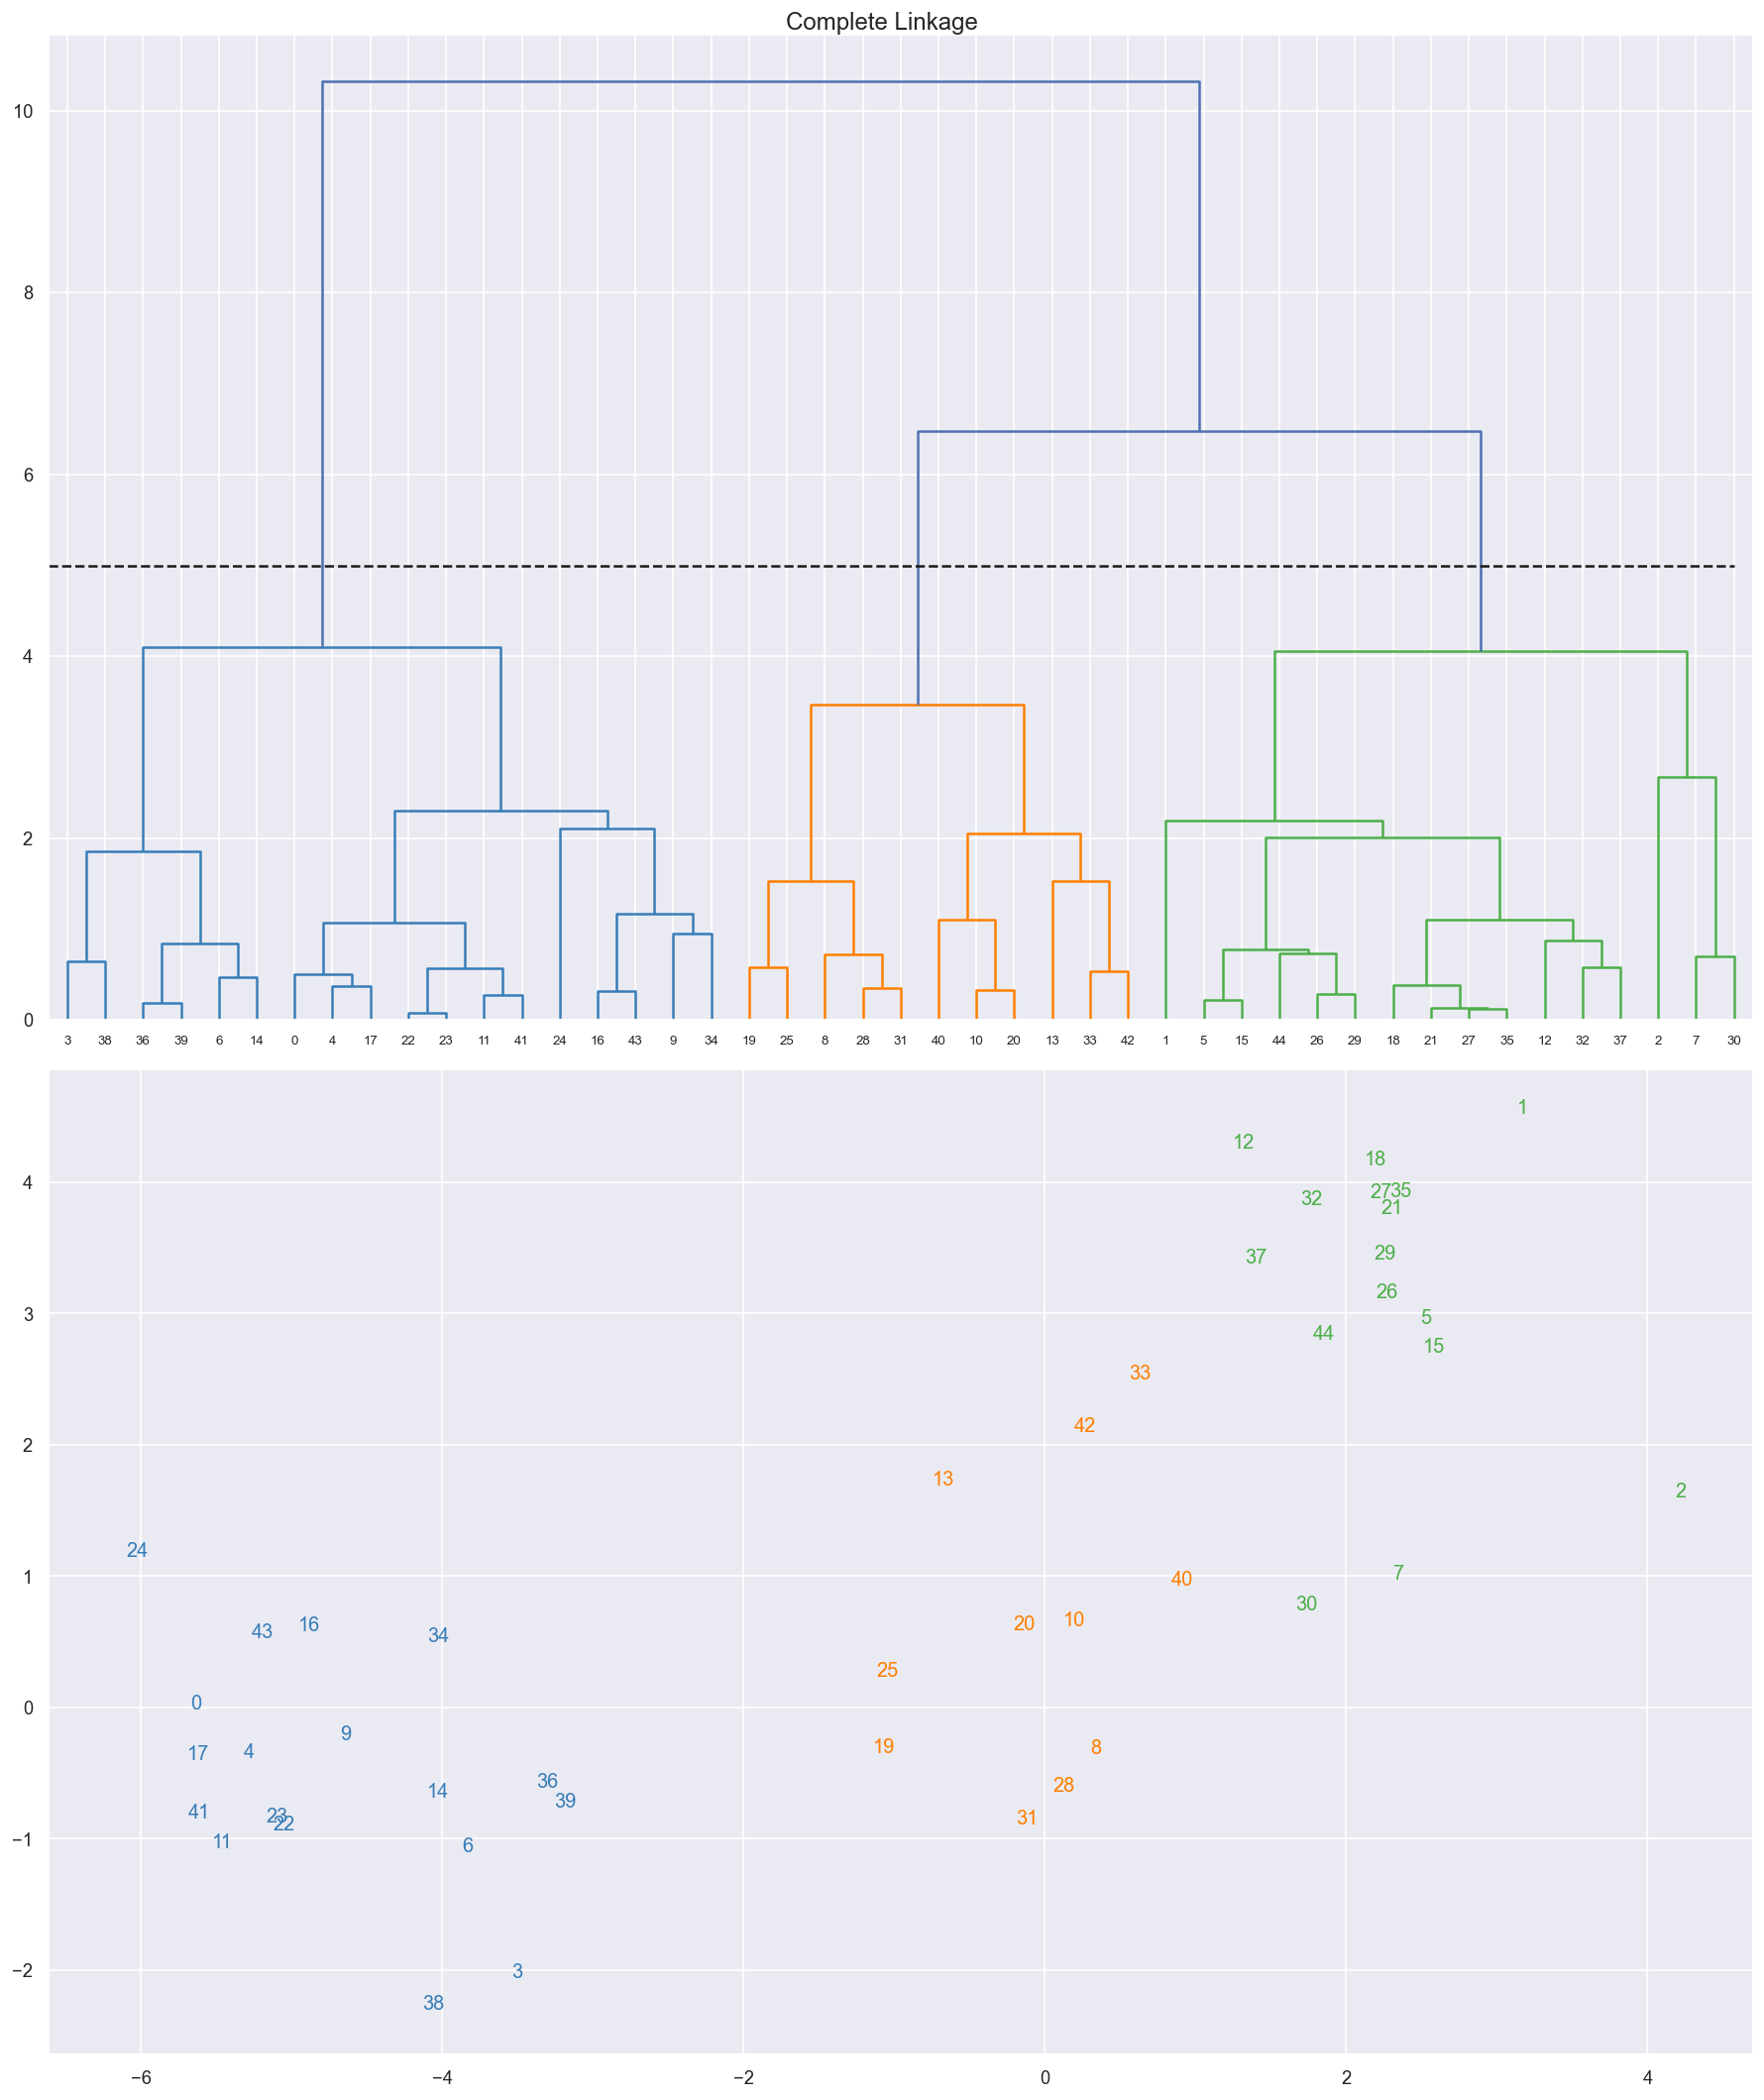

In [22]:
heir_scat_plot("Complete", points, threshold=5)

## Distance Measure

So far we have used Euclidean distance but other metrics exist.

__Correlation-based distance__<sup>1</sup>

- Considers two observations to be similar if their features are highly correlated.
- Values may be similar dispite being far apart in terms of Euclidean distance.

Choice is important but depends on data being clustered and the scientific question at hand.

# DBSCAN

__TODO__
- If time work on this or maybe make it an extra bit.
- from pgs.372 Python ML learning and pgs.255 of hands on ML.

## HDBSCAN

# Associated Exercises

Now might be a good time to try exercises X-X.

# Recommended Readings

An introduction to statistical learning (Chapter 10)

# References
1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer.
2. Raschka, S., & Mirjalili, V. (2019). Python machine learning: Machine learning and deep learning with Python, scikit-learn, and TensorFlow 2. Packt Publishing Ltd.
3. Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O'Reilly Media.

In [ ]:
!jupyter nbconvert 1_K_Means.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True